In [117]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.svm import SVC


import warnings
warnings.filterwarnings("ignore")

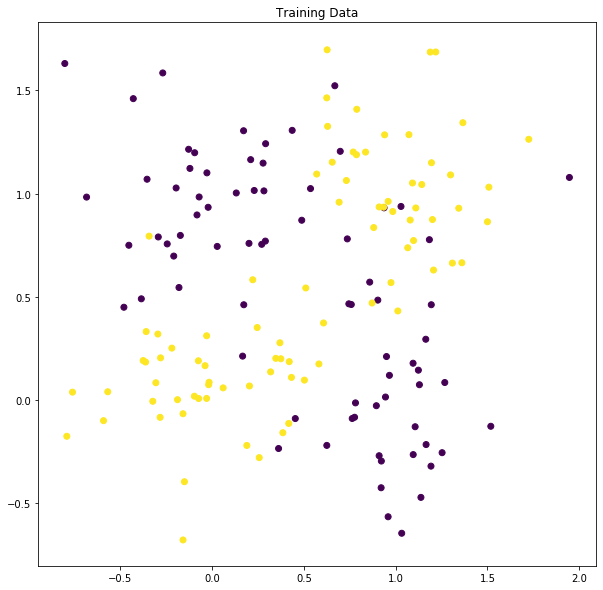

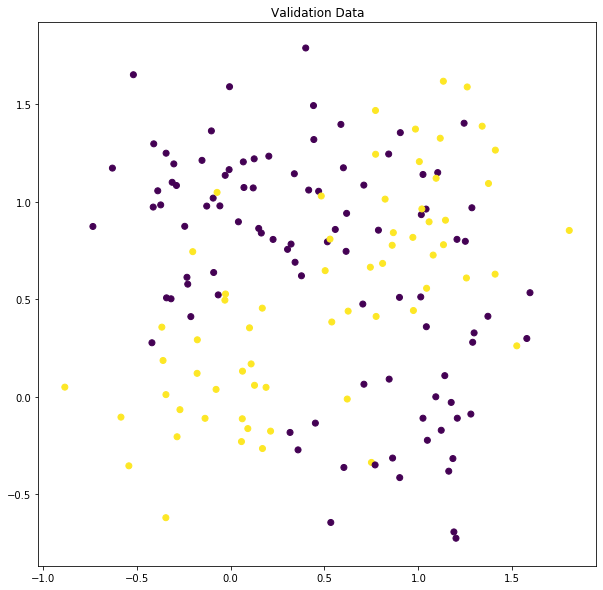

In [2]:
mean1 = np.array([0,1])
mean2 = np.array([1,0])
mean3 = np.array([0,0])
mean4 = np.array([1,1])

Means = np.array([mean1, mean2, mean3, mean4])

cov = np.eye(2) * .1

#Ideally you would pass it a mean_arr and and a cov_arr and then it would
#create data from the required amount of distributions

    
    
def generate_data (nsamples, mean1, mean2, cov1, cov2, nclasses):
    
    """
    Generates a number of samples from multivariate normal
    distributions with different means. 
    
    @params:
    nsamples: the number of samples to be generated
    mean1: the mean of the first multivariate gaussian
    mean2: the mean of the second multivariate gaussian
    cov1: the covariance matrix of the first mg
    cov2: the covariances matrix of the second mg
    """
    
    one = np.random.multivariate_normal(mean1, cov1, nsamples)
    two = np.random.multivariate_normal(mean2, cov2, nsamples)
    
    mask = np.random.choice(np.array([True, False]), nsamples)
    
    one_temp = one[mask]
    data1 = np.zeros((one_temp.shape[0], cov1.shape[0] + nclasses))
    data1[:,:cov.shape[0]] = one_temp
    data1[:,cov.shape[0]:] = np.eye(nclasses)[0]
    
    two_temp = two[np.invert(mask)]
    data2 = np.zeros((two_temp.shape[0], cov2.shape[0] + nclasses))
    data2[:,:cov.shape[0]] = two_temp
    data2[:,cov.shape[0]:] = np.eye(nclasses)[1]
    
    
    return np.concatenate((data1, data2), axis=0)


def plot_create_data (nsamples, Means, cov1, cov2, nclasses, String):
    
    #Training data:
    
    data1 = generate_data(nsamples, Means[0], Means[2], cov1, cov2, nclasses)
    data2 = generate_data(nsamples, Means[1], Means[3], cov1, cov2, nclasses)
    
    #data3 = generate_data(nsamples, mean1, mean2, cov1, cov2, nclasses)
    #data4 = generate_data(nsamples, mean3, mean4, cov1, cov2, nclasses)
    
    plt.figure(figsize = (10,10))
    plt.scatter(data1[:,0], data1[:,1], c = data1[:,3])
    plt.scatter(data2[:,0], data2[:,1], c = data1[:,3])
    plt.title("{} Data".format(String))
    
    
    
    return  np.concatenate((data1, data2,), axis = 0)


training_data = plot_create_data(80, Means, cov, cov, 2, "Training")
validation_data = plot_create_data(80, Means, cov, cov,2, "Validation")

In [121]:
#As it turns out, our data representation isn't very well
#suited to the problem at hand.

training_data2 = np.zeros((training_data.shape[0], 3))
training_data2[:,:2] = training_data[:,:2]
training_data2[:,2] = np.where(training_data[:,2] == 0, -1, 1)

validation_data2 = np.zeros((validation_data.shape[0], 3))
validation_data2[:,:2] = validation_data[:,:2]
validation_data2[:,2] = np.where(validation_data[:,2] == 0, -1, 1)

#Classify using RBF kernel:

def classify_svm (C, gamma, training_data, validation_data):
    
    """
    Trains C-SVM model on the labelled training data and applies 
    said model to the validation set.
    gamma, C: parameters of the rbf-kernel for kernel-based SVM
    training_data: the training data, inlcuding labels
    validation_data: the validation_data, including labels
    """
    
    clf = SVC(kernel = 'rbf',  C = C, gamma = gamma)
    
    #Fit the model:
    
    clf.fit(training_data[:,:2], training_data[:,2])
    
    #Compute predictions on hold-out set:
    
    prediction = clf.predict(np.array([validation_data[:,0], validation_data[:,1]]).T)
    
    decision = clf.decision_function(validation_data[:,:2])
    
    #Compute the loss
    
    loss = sklearn.metrics.zero_one_loss(validation_data[:,2],\
                                     prediction, normalize = True)
    
    return {"Model": clf, "Prediction": prediction, "Decision": decision, \
            "Loss" : loss}


def plot_decision_boundary (C, gamma, training_data, validation_data):
    
    clf = classify_svm(C, gamma, training_data, validation_data)["Model"]
    
    
    #Get Decision plane:
    
    x1_min, x1_max = training_data[:, 0].min() - 1, training_data[:, 0].max() + 1
    x2_min, x2_max = training_data[:, 1].min() - 1, training_data[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, .1),
                          np.arange(x2_min, x2_max, .1))
    
    #Getting Predictions on the decision plane:
    
    result = clf.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T)
    result = result.reshape(xx2.shape)
    plt.figure(figsize = (10,10))
    plt.contour(xx1, xx2, result, [-1,0,1], color = 'k', linestyles = ['--', '-', '--'], zorder = 1)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.legend()
    
    plt.scatter(validation_data[:,0], validation_data[:,1], \
                c = validation_data[:,2])
    plt.title('C-SVM classifier')
    plt.xlabel('X')
    plt.ylabel
    
    support_vecs = clf.support_vectors_
    
    plt.scatter(support_vecs[:,0], support_vecs[:,1],  \
                c= 'r', marker = 'x', label = "Support Vectors:{}"\
                .format(len(support_vecs)))
    plt.legend()
    

No handles with labels found to put in legend.


The loss of this model on the validation set is: 0.13749999999999996 


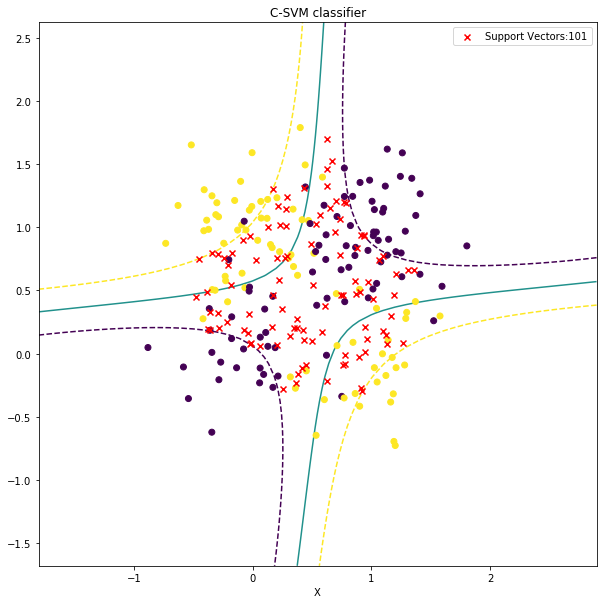

In [122]:
plot_decision_boundary(10,.1, training_data, validation_data)
print("The loss of this model on the validation set is:",
      classify_svm(10,.1, training_data, validation_data)["Loss"],"")

$ \textbf{Explanation:}$ The above plot shows the margins (dashed lines) and the decision boundary. The support vectors are shown as red crossmarks. Overlaid are the data points from the hold-out set.



In [128]:
def n_cross_validation (training_data, C_range, gamma_range, nfold):
    
    
    """
    Performs nfold crossvalidation and grdisearch on a parameter grid:
    @params:
    training_data: the training data 
    c_range: the range for the first parameter
    gamma_range: the range for the second parameter
    nfold: the split for crossvalidation
    """
    
    params = {'C': 2.0**C_range, 'gamma': 2.0**gamma_range}
    
    clf = SVC(kernel = 'rbf', random_state = 0)
    
    clf.fit(training_data[:,:2], training_data[:,2])
    
    grid = sklearn.model_selection.GridSearchCV(clf, params, cv= nfold)
    
    grid.fit(training_data[:,:2], training_data[:,2])
    
    scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),\
                                len(gamma_range))
    
    best_params = np.unravel_index(np.argmax(scores), scores.shape)
    
    best_c, best_gamma = params['C'][best_params[0]], \
                         params['gamma'][best_params[1]]


    return scores, best_c, best_gamma

C_range, gamma_range = np.arange(-6, 10, 2), np.arange(-5,10,2)

#Refining the scale on the basis of the obtained results:

C_range_refined, gamma_range_refined = np.arange(7,9,.1), \
                                       np.arange(-4,-2,.1)
result = n_cross_validation(training_data, C_range, gamma_range, 10)

print(r"The best parameters are: C = {}, $\gamma$ = {}".format(\
                                            result[1], result[2]))


The best parameters are: C = 256.0, $\gamma$ = 0.125


No handles with labels found to put in legend.
No handles with labels found to put in legend.


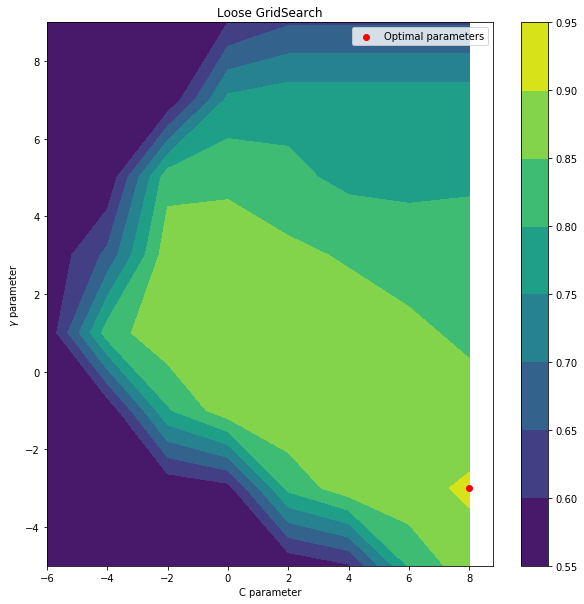

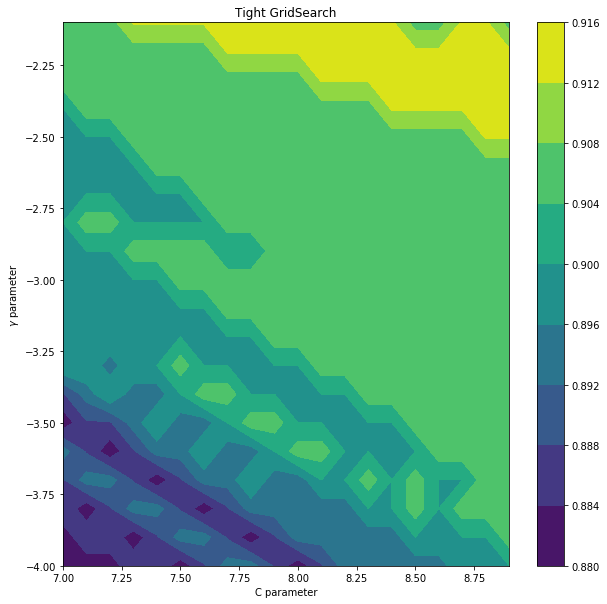

<Figure size 720x720 with 0 Axes>

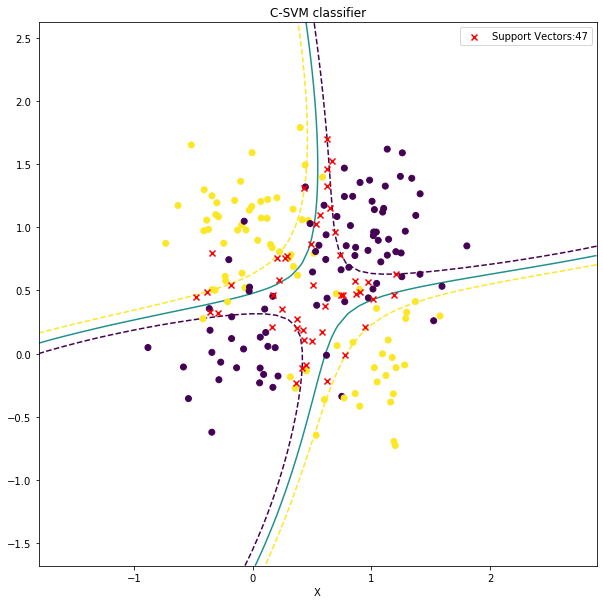

<Figure size 720x720 with 0 Axes>

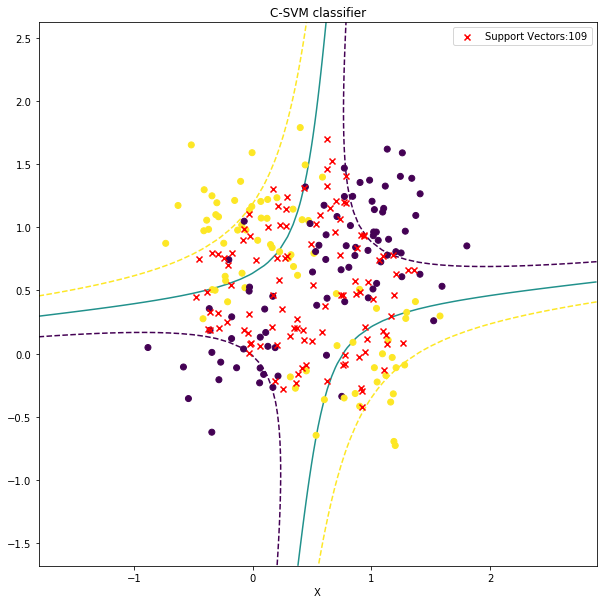

In [142]:
#Using those parameters to train on the full training set:

def plot_contours(training_data, C_range, gamma_range, nfold):
    
    result =  n_cross_validation(training_data, C_range, \
                           gamma_range, 10)
    
    Gs, Cs = np.meshgrid(gamma_range, C_range)
    
    plt.contourf(Cs, Gs, result[0])
    plt.colorbar();

plt.figure(figsize= (10,10))
plot_contours(training_data, C_range, gamma_range, 10)
plt.scatter(np.log2(result[1]), np.log2(result[2]), c = 'r',\
            label = 'Optimal parameters')
plt.title('Loose GridSearch')
plt.xlabel('C parameter')
plt.ylabel('$\gamma$ parameter')
plt.legend()
plt.figure(figsize = (10,10))
plot_contours(training_data, C_range_refined, gamma_range_refined, 10)
plt.title('Tight GridSearch')
plt.xlabel('C parameter')
plt.ylabel('$\gamma$ parameter')
plt.figure(figsize = (10,10))      
plot_decision_boundary(result[1], result[2], \
                       training_data, validation_data)

plt.figure(figsize = (10,10))
plot_decision_boundary(result[1] / 4, result[2] / 4, \
                       training_data, validation_data)



$\textbf{Answer:}$ The two contour plots show the performance of the SVm classifier on different combinations of the $C$ and $\gamma$ parameters. Whereas the first uses a relatively loose grid as an initial probe, the second one searches more closely around the peak of the first contour. Indeed, this analysis reveals that there was a high performance region (the thin strip at the top of the second plot) that was missed in the first search.\\

$\textbf{Answer 2:}$ A we compare the two bottom plots with each other (and with the initial plot obtained from running the SVM with random parameters) we can observe the following things: First, with optimal  parameters the decision boundary matches the class boundaries fairly well. The classification performance increases and the number of support vectors decreases. The bottommost plot shows that the performance reverts to its initial level, when both parameters are divided by 4. When only one of them is divided, the performance does not change significantly. This could have been guessed from the topmost contourplot, because there, as we move in either direction of the optimum, the performance does not seem to change significantly.

In [138]:
np.log2(4)

2.0